#### 프로젝트 : mini BERT 만들기
##### 학습목표
1. [X] 한글 코퍼스를 가공하여 BERT pretrain용 데이터셋을 잘 생성하였다.
2. [X] 구현한 BERT 모델의 학습이 안정적으로 진행됨을 확인하였다.
3. [X] Vocab size를 8000으로 줄이고, 1M짜리 mini BERT 모델의 제작과 학습이 정상적으로 진행되었다.
##### 평가기준
1. [X] MLM, NSP task의 특징이 잘 반영된 pretrain용 데이터셋 생성과정이 체계적으로 진행되었다.
2. [X] 학습진행 과정 중에 MLM, NSP loss의 안정적인 감소가 확인되었다.
3. [X] 학습된 모델 및 학습과정의 시각화 내역이 제출되었다.

##### 다운로드

In [1]:
# !wget https://d3s0tskafalll9.cloudfront.net/media/documents/kowiki.txt.zip
# !unzip kowiki.txt.zip
# !pip install sentencepiece
# !pip install tqdm
# !conda install -y -c conda-forge ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !pip install torchsummary

##### 라이브러리

In [2]:
# __future__ 모듈 불러오기 (파이썬 버전 호환성 보장용)
from __future__ import absolute_import, division, print_function, unicode_literals

# PyTorch 관련 라이브러리
import torch
import torch.nn as nn                 # 신경망 레이어 정의
import torch.nn.functional as F       # 활성화 함수 및 손실 함수
import torch.optim as optim           # 최적화 알고리즘 (SGD, Adam 등)
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로딩/배치 구성
from torchsummary import summary      # 모델 구조 요약 (Keras summary 유사)
from torchinfo import summary         # 더 상세한 모델 summary

# 파이썬 표준 라이브러리
import os, re, math, random, json, shutil, zipfile, copy
import numpy as np
import pandas as pd
import collections
from datetime import datetime

# 시각화 및 학습 진행 상황 표시
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm        # 학습 진행 상태 Progress Bar
import sentencepiece as spm           # 토크나이저 (SentencePiece)

# 랜덤 시드 고정 (재현 가능성 확보)
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)

##### Tokenizer 준비

In [3]:
# 위키 코퍼스 파일 경로 (학습 데이터)
corpus_file = "kowiki.txt"

# 학습된 모델의 저장 prefix (모델/단어 사전 파일 이름 접두사)
prefix = "ko_8000"

# 단어 사전 크기 (vocab size)
vocab_size = 8000

# SentencePieceTrainer를 사용한 BPE 토크나이저 학습
# 실제 실행 시 주석을 해제해서 사용합니다.
# - vocab_size + 7 : [PAD], [UNK], [BOS], [EOS], [SEP], [CLS], [MASK] 7개 특수토큰 추가
# - model_type=bpe : Byte-Pair Encoding 방식 사용
# - max_sentence_length=999999 : 문장 최대 길이 설정
# - user_defined_symbols : 추가 사용자 정의 토큰 설정
"""
spm.SentencePieceTrainer.train(
    f"--input={corpus_file} "
    f"--model_prefix={prefix} "
    f"--vocab_size={vocab_size + 7} "
    f"--model_type=bpe "
    f"--max_sentence_length=999999 "
    f"--pad_id=0 --pad_piece=[PAD] "
    f"--unk_id=1 --unk_piece=[UNK] "
    f"--bos_id=2 --bos_piece=[BOS] "
    f"--eos_id=3 --eos_piece=[EOS] "
    f"--user_defined_symbols=[SEP],[CLS],[MASK]"
)
"""

'\nspm.SentencePieceTrainer.train(\n    f"--input={corpus_file} "\n    f"--model_prefix={prefix} "\n    f"--vocab_size={vocab_size + 7} "\n    f"--model_type=bpe "\n    f"--max_sentence_length=999999 "\n    f"--pad_id=0 --pad_piece=[PAD] "\n    f"--unk_id=1 --unk_piece=[UNK] "\n    f"--bos_id=2 --bos_piece=[BOS] "\n    f"--eos_id=3 --eos_piece=[EOS] "\n    f"--user_defined_symbols=[SEP],[CLS],[MASK]"\n)\n'

In [4]:
# SentencePieceProcessor 객체 생성
vocab = spm.SentencePieceProcessor()

# 학습된 SentencePiece 모델 로드 (.model 파일)
# -> ko_8000.model 과 ko_8000.vocab 파일이 같은 위치에 있어야 함
vocab.load("ko_8000.model")

True

In [5]:
# 학습된 vocab에서 특수 토큰([PAD]~[MASK])을 제외한 실제 토큰 리스트 생성
vocab_list = []
for id in range(7, len(vocab)):  # 0~6은 특수토큰, 7번부터 일반 토큰 시작
    if not vocab.is_unknown(id):              # [UNK]가 아닌 경우만 추가
        vocab_list.append(vocab.id_to_piece(id))  # 토큰 ID → 실제 토큰 문자열 변환

# 학습된 토큰 중 앞 100개만 출력 (샘플 확인용)
print(vocab_list[:100])

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다', '었다', '▁지', '▁수', '▁19', '▁가', '▁시', '▁20', '▁기', '▁전', '▁아', '▁하', '▁있다', '▁다', '▁제', '했다', '하였', '▁일', '▁한', '▁중', '▁정', '▁주', '하는', '▁것', '▁자', '▁공', '▁인', '되었다', '▁경', '▁위', '▁유', '▁보', '하고', '▁3', '▁등', '▁부', '하였다', '▁조', '하여', '▁미', '▁동', '▁선', '▁나', '으며', '▁모', '▁연', '▁영', '▁의', '▁오', '▁마', '에는', '▁발', '▁소', '한다', '▁고', '▁개', '▁201', '▁구', '▁세', '▁도', '▁상', '▁비', '▁스', '▁국', '▁서', '▁후', '▁여', '▁200', '▁때', '▁4', '▁성', '▁해', '▁관', '▁있는', '▁신', '▁프', '▁대한', '부터', '▁5', '▁방', '▁또', '지만', '▁(', '▁역', '되어', '▁않', '▁만', '▁"', '▁장', '▁바', '까지']


In [6]:
# 입력 문장 A와 B 정의
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"

# 문장 A, B를 SentencePiece 토큰화 후
# BERT 입력 형식에 맞게 [CLS] + A + [SEP] + B + [SEP] 형태로 구성
tokens_org = (
    ["[CLS]"] 
    + vocab.encode_as_pieces(string_a) 
    + ["[SEP]"] 
    + vocab.encode_as_pieces(string_b) 
    + ["[SEP]"]
)

# 변환된 토큰 시퀀스 출력
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


##### 데이터 전처리 (1) MASK 생성

In [7]:
# 변환된 토큰 시퀀스 출력 (확인용)
print(tokens_org)

# [CLS], [SEP], [SEP] 3개 특수토큰 제외
# 나머지 토큰 중 15%를 마스킹 대상으로 설정
mask_cnt = int((len(tokens_org) - 3) * 0.15)

# 마스크 대상 개수 출력
mask_cnt

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


14

In [8]:
cand_idx = []  
for (i, token) in enumerate(tokens_org):
    # 특수 토큰([CLS], [SEP])은 마스킹 후보에서 제외
    if token == "[CLS]" or token == "[SEP]":
        continue
    
    # SentencePiece에서 단어 시작은 "▁"(U+2581) 로 표시됨
    # 만약 현재 토큰이 단어의 연속이라면 → 직전 후보 리스트에 추가
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  
        cand_idx[-1].append(i)
    else:
        # 새로운 단어 시작
        cand_idx.append([i])

# 후보 인덱스 및 실제 토큰 출력 (확인용)
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1, 2, 3, 4] ['▁추', '적', '추', '적']
[5, 6] ['▁비', '가']
[7, 8] ['▁내', '리는']
[9, 10, 11] ['▁날', '이었', '어']
[12, 13, 14] ['▁그', '날', '은']
[15, 16, 17] ['▁', '왠', '지']
[18, 19, 20] ['▁손', '님', '이']
[21, 22] ['▁많', '아']
[23] ['▁첫']
[24, 25] ['▁번', '에']
[26, 27] ['▁삼', '십']
[28] ['▁전']
[29, 30, 31] ['▁둘', '째', '번']
[32, 33] ['▁오', '십']
[34] ['▁전']
[35, 36, 37] ['▁오', '랜', '만에']
[38, 39, 40] ['▁받아', '보', '는']
[41] ['▁십']
[42, 43, 44] ['▁전', '짜', '리']
[45, 46, 47] ['▁백', '통', '화']
[48, 49, 50] ['▁서', '푼', '에']
[52, 53, 54] ['▁손', '바', '닥']
[55, 56] ['▁위', '엔']
[57, 58, 59] ['▁기', '쁨', '의']
[60, 61] ['▁눈', '물이']
[62, 63] ['▁흘', '러']
[64, 65, 66] ['▁컬', '컬', '한']
[67, 68] ['▁목', '에']
[69, 70] ['▁모', '주']
[71, 72, 73] ['▁한', '잔', '을']
[74, 75] ['▁적', '셔']
[76] ['▁몇']
[77] ['▁달']
[78] ['▁포']
[79, 80] ['▁전', '부터']
[81, 82, 83, 84] ['▁콜', '록', '거', '리는']
[85] ['▁아내']
[86, 87] ['▁생각', '에']
[88, 89, 90] ['▁그', '토', '록']
[91, 92] ['▁먹', '고']
[93, 94, 95] ['▁싶', '다', '던']


In [9]:
# 단어 단위 후보 인덱스 리스트를 랜덤 셔플
random.shuffle(cand_idx)

# 섞인 후보 인덱스 출력
cand_idx

[[24, 25],
 [57, 58, 59],
 [32, 33],
 [64, 65, 66],
 [41],
 [79, 80],
 [52, 53, 54],
 [67, 68],
 [29, 30, 31],
 [91, 92],
 [23],
 [26, 27],
 [76],
 [42, 43, 44],
 [78],
 [60, 61],
 [38, 39, 40],
 [93, 94, 95],
 [9, 10, 11],
 [81, 82, 83, 84],
 [85],
 [12, 13, 14],
 [34],
 [71, 72, 73],
 [77],
 [45, 46, 47],
 [48, 49, 50],
 [28],
 [74, 75],
 [62, 63],
 [88, 89, 90],
 [5, 6],
 [35, 36, 37],
 [55, 56],
 [18, 19, 20],
 [86, 87],
 [7, 8],
 [15, 16, 17],
 [1, 2, 3, 4],
 [21, 22],
 [69, 70]]

In [10]:
# 원본 토큰 시퀀스를 복사 (원본은 보존)
tokens = copy.deepcopy(tokens_org)

mask_lms = []  # 마스크된 토큰 정보 (index, label) 저장 리스트
for index_set in cand_idx:
    # 마스크할 개수를 초과하면 종료
    if len(mask_lms) >= mask_cnt:
        break
    # 단어 단위 마스킹 시, 전체 개수를 초과하지 않도록 제어
    if len(mask_lms) + len(index_set) > mask_cnt:
        continue
    
    # dice 값으로 마스킹 유형 결정 (80/10/10 규칙)
    dice = random.random()
    for index in index_set:
        masked_token = None
        if dice < 0.8:        # 80% 확률 → [MASK] 토큰으로 대체
            masked_token = "[MASK]"
        elif dice < 0.9:      # 10% 확률 → 원래 토큰 유지
            masked_token = tokens[index]
        else:                 # 10% 확률 → 랜덤 토큰으로 대체
            masked_token = random.choice(vocab_list)

        # 마스크된 위치와 정답 토큰(label)을 기록
        mask_lms.append({"index": index, "label": tokens[index]})
        # 실제 입력 토큰 시퀀스 갱신
        tokens[index] = masked_token

# 결과 확인
print("tokens_org")  # 원본 토큰 시퀀스
print(tokens_org, "\n")
print("tokens")      # 마스킹된 토큰 시퀀스
print(tokens)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[MASK]', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MASK]', '[MASK]', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '프', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '[MASK]', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘', '러', '[MASK]', '[MASK]', '[MASK]', '▁목', '에'

In [11]:
# 마스크된 토큰들을 index 순서대로 정렬
mask_lms = sorted(mask_lms, key=lambda x: x["index"])

# 마스크 위치(index) 리스트
mask_idx = [p["index"] for p in mask_lms]

# 정답 레이블(원래 토큰) 리스트
mask_label = [p["label"] for p in mask_lms]

# 결과 확인
print("mask_idx   :", mask_idx)     # 마스킹된 위치
print("mask_label :", mask_label)   # 해당 위치의 원래 토큰(정답)

mask_idx   : [23, 24, 25, 32, 33, 41, 57, 58, 59, 64, 65, 66, 79, 80]
mask_label : ['▁첫', '▁번', '에', '▁오', '십', '▁십', '▁기', '쁨', '의', '▁컬', '컬', '한', '▁전', '부터']


In [12]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    BERT Pre-training용 MLM 마스킹 함수
    Args:
        tokens (list): 입력 토큰 시퀀스 (BERT 포맷: [CLS] ... [SEP] ... [SEP])
        mask_cnt (int): 전체 토큰 중 마스킹할 개수
        vocab_list (list): 랜덤 치환 시 사용할 일반 토큰 리스트
    Returns:
        tokens (list): 마스킹이 적용된 토큰 시퀀스
        mask_idx (list): 마스킹된 위치 인덱스
        mask_label (list): 각 위치의 정답 레이블 토큰
    """
    cand_idx = []
    for (i, token) in enumerate(tokens):
        # 특수 토큰([CLS], [SEP])은 마스킹 대상에서 제외
        if token == "[CLS]" or token == "[SEP]":
            continue
        # SentencePiece에서 '▁' (U+2581)로 단어 경계 구분
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)   # 직전 단어에 이어붙이기
        else:
            cand_idx.append([i])     # 새로운 단어 시작

    # 마스킹 후보 순서를 랜덤 셔플
    random.shuffle(cand_idx)

    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:            # 목표 개수 채우면 종료
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue

        # 80/10/10 규칙 적용
        dice = random.random()
        for index in index_set:
            if dice < 0.8:          # 80%: [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9:        # 10%: 원래 토큰 그대로
                masked_token = tokens[index]
            else:                   # 10%: 랜덤 토큰으로 대체
                masked_token = random.choice(vocab_list)

            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # 마스킹 위치 정렬 (index 순서대로)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label# 원본 토큰 시퀀스를 복사 (원본 유지)
tokens = copy.deepcopy(tokens_org)

# 마스킹 적용 (MLM 데이터 생성)
tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

# 결과 출력
print("tokens_org")   # 원본 입력 토큰
print(tokens_org, "\n")

print("tokens")       # 마스킹된 입력 토큰
print(tokens, "\n")

print("mask_idx   :", mask_idx)     # 마스킹된 위치 인덱스
print("mask_label :", mask_label)   # 각 위치의 원래 토큰(정답)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '[MASK]', '[MASK]', '[MASK]', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '팹', '著', '內', '[SEP]', '▁손', '바', '닥', '[MASK]', '[MASK]', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '[MASK]', '[MASK]', '▁한', 

In [13]:
tokens = copy.deepcopy(tokens_org)
tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)
print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")
print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁비', '가', '[MASK]', '[MASK]', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '[MASK]', '[MASK]', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '[MASK]', '[MASK]', '가로', '21', '▁컬', '컬', '한', '▁목', '에', '▁

##### 데이터 전처리 (2) NSP pair 생성

In [14]:
# 학습용 입력 문자열 (여러 줄로 구성된 텍스트)
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [15]:
# 여러 줄로 구성된 string을 줄 단위로 분할 → 각 줄을 SentencePiece 토큰화
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]

# 앞 3개 문장 토큰화 결과 확인
doc[:3]

[['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'],
 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'],
 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전']]

In [16]:
# 최대 입력 길이 (하나의 학습 예시 토큰 개수)
n_test_seq = 64

# 최소 시퀀스 길이 (너무 짧은 문장은 제외)
min_seq = 8

# 최대 시퀀스 길이 (특수토큰 [CLS], [SEP], [SEP] 3개 고려)
max_seq = n_test_seq - 3

In [17]:
current_chunk = []   # 문장들을 묶어둘 버퍼
current_length = 0   # 현재 묶음의 총 토큰 길이

for i in range(len(doc)):
    # 문장 추가
    current_chunk.append(doc[i])
    current_length += len(doc[i]) 
    
    # 조건 충족 시 → 하나의 학습 샘플로 분리
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
        print("current_chunk:", len(current_chunk), current_length, current_chunk)
        
        # 문장 경계 랜덤 선택 → 앞/뒤 문장 분리
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
            
        # 앞쪽 문장 묶음 → tokens_a
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])

        # 뒤쪽 문장 묶음 → tokens_b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        # 결과 확인
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        print()
        
        # 초기화 (다음 chunk 준비)
        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
tokens_a: 22 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아']
tokens_b: 40 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '

In [18]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    NSP 학습용 문장 쌍의 길이를 max_seq 이하로 잘라내는 함수
    Args:
        tokens_a (list): 문장 A 토큰 리스트
        tokens_b (list): 문장 B 토큰 리스트
        max_seq (int): 최대 시퀀스 길이 (특수토큰 제외)
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:   # 길이가 허용 범위 내면 종료
            break
        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]          # A가 길면 앞쪽에서 잘라내기
        else:
            tokens_b.pop()           # B가 길면 뒤쪽에서 잘라내기

In [19]:
current_chunk = []  
current_length = 0

for i in range(len(doc)):  
    # 문장 추가
    current_chunk.append(doc[i])  
    current_length += len(doc[i])  
    
    # 조건 충족 시 → 문장 쌍 생성
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq): 
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # 문장 경계 무작위 선택
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        
        # 앞쪽 문장 묶음
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])

        # 뒤쪽 문장 묶음
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        # 50% 확률로 문장 쌍 순서를 뒤바꿔 is_next = 0 생성
        if random.random() < 0.5: 
            is_next = 0   # False (랜덤 Negative 예시)
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1   # True (실제 문장 순서)

        # 길이 제한 적용
        trim_tokens(tokens_a, tokens_b, max_seq)

        # 안전성 체크
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        # 결과 확인
        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        print()

        # 초기화 후 다음 chunk 준비
        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 1
tokens_a: 49 ['적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에']
tokens_b: 12 ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제

In [20]:
instances = []          # 최종 학습 데이터 저장 리스트
current_chunk = []  
current_length = 0

for i in range(len(doc)):  
    # 문장 추가
    current_chunk.append(doc[i]) 
    current_length += len(doc[i])  
    
    # 조건 충족 시 → 문장 쌍 생성
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  
        print("current_chunk:", len(current_chunk), current_length, current_chunk)
        
        # 문장 경계 무작위 분할
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        
        # A, B 문장 생성
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        # 50% 확률로 is_next = 0 (랜덤 Negative)
        if random.random() < 0.5:  
            is_next = 0    
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1   

        # 길이 제한 적용
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)

        # 최종 입력 시퀀스 구성 ([CLS] A [SEP] B [SEP])
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]

        # Segment ID 생성 (A=0, B=1)
        segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        print("tokens:", len(tokens), tokens)
        print("segment:", len(segment), segment)

        # MLM 마스킹 적용
        tokens, mask_idx, mask_label = create_pretrain_mask(
            tokens, int((len(tokens) - 3) * 0.15), vocab_list
        )
        print("masked tokens:", len(tokens), tokens)
        print("masked index:", len(mask_idx), mask_idx)
        print("masked label:", len(mask_label), mask_label)

        # 인스턴스 저장
        instance = {
            "tokens": tokens,
            "segment": segment,
            "is_next": is_next,
            "mask_idx": mask_idx,
            "mask_label": mask_label
        }
        instances.append(instance)
        print()

        # 초기화
        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 0
tokens_a: 39 ['▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']
tokens_b: 22 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아']
tokens: 64 ['[CLS]', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적

In [21]:
# instances 리스트에 저장된 학습용 데이터 샘플들을 출력
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁번', '에', '▁삼', '십', '▁전', '[MASK]', '[MASK]', '▁번', '▁오', '십', '굶', '▁오', '랜', '만에', '▁받아', '보', '는', '[MASK]', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '[MASK]', '[MASK]', '[MASK]', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [6, 7, 11, 18, 49, 50, 51, 61, 62], 'mask_label': ['▁둘', '째', '▁전', '▁십', '▁날', '이었', '어', '▁많', '아']}
{'tokens': ['[CLS]', '컬', '한', '[MASK]', '[MASK]', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '[MASK]', '▁달', '[MASK]', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]', '▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제

In [22]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    BERT Pre-training 학습 인스턴스를 생성하는 함수
    Args:
        vocab (SentencePieceProcessor): 학습된 토크나이저
        doc (list): 문서 단위 토큰화 결과 (문장별 토큰 리스트)
        n_seq (int): 전체 시퀀스 최대 길이 ([CLS], [SEP], [SEP] 포함)
        mask_prob (float): 마스킹 비율 (ex: 0.15 = 15%)
        vocab_list (list): 랜덤 치환에 사용할 일반 토큰 리스트
    Returns:
        instances (list): 학습 샘플 리스트 (딕셔너리 구조)
    """
    max_seq = n_seq - 3     # [CLS], [SEP], [SEP] 제외한 최대 토큰 길이
    instances = []
    current_chunk = []
    current_length = 0
    
    for i in range(len(doc)):
        # 문장 누적
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        
        # 조건 충족 시 → 하나의 학습 샘플 생성
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # 랜덤 경계 선택
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            
            # 앞쪽 문장 A
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            
            # 뒤쪽 문장 B
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            # 50% 확률로 NSP Negative 샘플 생성
            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1

            # 길이 제한 적용
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            # 최종 입력 시퀀스 구성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]

            # Segment ID 생성 (A=0, B=1)
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            # MLM 마스킹 적용
            tokens, mask_idx, mask_label = create_pretrain_mask(
                tokens, int((len(tokens) - 3) * mask_prob), vocab_list
            )

            # 인스턴스 저장
            instance = {
                "tokens": tokens,          # [MASK]가 적용된 입력 토큰 시퀀스
                "segment": segment,        # NSP용 Segment 구분
                "is_next": is_next,        # NSP 라벨
                "mask_idx": mask_idx,      # MLM 마스크 위치
                "mask_label": mask_label   # MLM 정답 토큰
            }
            instances.append(instance)

            # 초기화 (다음 chunk 준비)
            current_chunk = []
            current_length = 0

    return instances

In [23]:
# NSP + MLM 학습용 인스턴스 생성
instances = create_pretrain_instances(
    vocab,          # SentencePiece 토크나이저
    doc,            # 문장 단위 토큰화된 문서
    n_test_seq,     # 최대 시퀀스 길이 (64)
    0.15,           # 마스킹 확률 (15%)
    vocab_list      # 랜덤 치환용 일반 토큰 리스트
)

# 생성된 인스턴스 출력
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '↔', '숨', '▁날', '이었', '어', '[SEP]', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '틋', '[MASK]', '[MASK]', '[MASK]', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[MASK]', '[MASK]', '[MASK]', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 1, 'mask_idx': [7, 8, 32, 33, 34, 35, 52, 53, 54], 'mask_label': ['▁내', '리는', '▁번', '▁오', '십', '▁전', '▁손', '바', '닥']}
{'tokens': ['[CLS]', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '[MASK]', '[MASK]', '▁있어', '▁집', '으로', '▁돌아', '가는', '▁길', '▁난', '▁문', '득', '▁떠', '올', '라', '▁아내', '의', '▁목', '소', '리가', '▁거', '칠', '어', '만',

##### 데이터 전처리 (3) 데이터셋 완성

In [24]:
corpus_file = "kowiki.txt"
total = 0

# 파일 열어서 한 줄씩 읽으며 카운트
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

# 전체 문장 수 출력
total

3957761

In [25]:
count = 5  # 처음 5개 문서만 출력해보기

with open(corpus_file, 'r') as in_f:
    doc = []  
    for line in tqdm(in_f, total=total):   # tqdm으로 전체 진행률 표시
        line = line.strip()
        
        if line == "":  # 빈 줄 → 문서 경계
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])   # 첫 문장
                    print(doc[1])                        # 두 번째 문장
                    print(doc[-1])                       # 마지막 문장
                    print()
                else:
                    break
                doc = []  # 문서 초기화
        else: 
            # 문장을 SentencePiece 토큰화
            pieces = vocab.encode_as_pieces(line)
            if 0 < len(pieces):
                doc.append(pieces)

    # 마지막에 남아 있는 문서 처리
    if 0 < len(doc):  
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

21 lines : ['▁지', '미', '▁카', '터']
['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카', '터', '▁주', '니어', '(,', '▁192', '4', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '7', '7', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁그는', '▁2002', '년', '▁말', '▁인', '권', '과', '▁중', '재', '▁역할', '에', '▁대한', '▁공', '로를', '▁인정', '받아', '▁노', '벨', '▁평화', '상을', '▁받', '게', '▁되었다', '.']

14 lines : ['▁수학']
['▁수학', '(', '數', '學', ',', '▁)', '은', '▁양', ',', '▁구조', ',', '▁공간', ',', '▁변화', ',', '▁미', '적', '분', '▁등의', '▁개념', '을', '▁다루', '는', '▁학', '문', '이다', '.', '▁현대', '▁수학', '은', '▁형식', '▁논', '리를', '▁이용', '해서', '▁공', '리로', '▁구성된', '▁추', '상', '적', '▁구조를', '▁연구', '하는', '▁학', '문', '으로', '▁여겨', '지', '기도', '▁한다', '.', '▁수학', '은', '▁그', '▁구조', '와', '▁발전', '▁과정', '에서는', '▁자연', '과학', '에', '▁속하는', '▁물리', '학을', '▁비롯한', '▁다른', '▁학', '문', '들과', '▁깊', '은', '▁연', '관을', '▁맺', '고', '▁있다', '.', '▁하지만', ',', '▁어느', '▁과학', '의', '▁분야', '들과', '는', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지',

In [26]:
count = 5
with open(corpus_file, 'r') as in_f:
    doc = [] 
    for line in tqdm(in_f, total=total):
        line = line.strip()
        
        if line == "":  # 문서 경계
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # 인스턴스 생성 결과 출력
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])   # 첫 인스턴스
                print(instances[-1])  # 마지막 인스턴스
                print()
                
                doc = []  # 초기화
                if 0 < count: 
                    count -= 1
                else:
                    break
        else:  
            # 문장 토큰화
            pieces = vocab.encode_as_pieces(line)
            if 0 < len(pieces):
                doc.append(pieces)
    
    # 마지막 문서 처리
    if 0 < len(doc):  
        instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

doc: 21 instances: 10
{'tokens': ['[CLS]', '▁주', '니어', '(,', '[MASK]', '[MASK]', '[MASK]', '▁10', '월', '[MASK]', '[MASK]', '▁~', '▁)', '는', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '[MASK]', '▁(19', '7', '7', '년', '▁~', '▁1981', '년', ')', '이다', '.', '[SEP]', '▁지', '미', '▁카', '터', '는', '▁조지', '아', '주', '▁섬', '터', '▁카운', '티', '▁플', '레', '인', '스', '▁마을', '에서', '[MASK]', '[MASK]', '▁조지', '아', '▁공', '과', '대학교', '를', '▁졸업', '하였다', '.', '▁그', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 1, 'mask_idx': [4, 5, 6, 9, 10, 21, 26, 51, 52], 'mask_label': ['▁192', '4', '년', '▁1', '일', '▁대통령', '▁~', '▁태어났다', '.']}
{'tokens': ['[CLS]', '▁그는', '▁2002', '년', '▁말', '▁인', '권', '과', '▁중', '재', '[MASK]', '[MASK]', '[MASK]', '▁공', '로를', '▁인정', '받아', '▁노', '벨', '▁평화', '상을', '▁받', '게', '[MASK]', '[MASK]', '[SEP]', '[MASK]', '[MASK

In [27]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """
    BERT 프리트레이닝용 학습 데이터 생성 함수
    Args:
        vocab (SentencePieceProcessor): 학습된 토크나이저
        in_file (str): 입력 파일 경로 (코퍼스, 예: kowiki.txt)
        out_file (str): 출력 파일 경로 (JSONL 포맷)
        n_seq (int): 최대 시퀀스 길이 ([CLS], [SEP], [SEP] 포함)
        mask_prob (float): 마스킹 비율 (기본 15%)
    """
    # 내부 함수: 한 문서(doc) 단위로 인스턴스 생성 & 저장
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            # JSONL (한 줄 = 하나의 instance)
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # vocab_list 구성 (특수토큰 제외)
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # 전체 라인 수 세기 (tqdm 진행 표시용)
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    # 코퍼스 파일 읽어서 학습 인스턴스 생성 및 저장
    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # 빈 줄 = 문서 경계
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)

            # 마지막 문서 처리
            if 0 < len(doc):
                save_pretrain_instances(out_f, doc)
                doc = []

In [28]:
# 출력될 프리트레이닝 데이터 경로
pretrain_json_path = "bert_pre_train.json"

# 위 주석을 해제하면 학습 데이터 생성이 실행됩니다.
# - vocab : SentencePiece 토크나이저
# - corpus_file : 입력 위키 코퍼스 파일 (예: kowiki.txt)
# - pretrain_json_path : 출력 JSONL 파일
# - 128 : 최대 시퀀스 길이
# make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

In [29]:
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:     # 한 줄 = 하나의 인스턴스
        total += 1

# 전체 학습 인스턴스 개수 출력
total

918189

In [30]:
n_seq = 128
max_seq = n_seq - 3  # [CLS], [SEP], [SEP] 제외한 길이

# 메모리 효율적인 대규모 배열 저장 (memmap 사용)
enc_tokens = np.memmap(
    filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq)
)  # 입력 토큰 ID
segments = np.memmap(
    filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq)
)  # Segment IDs
labels_nsp = np.memmap(
    filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,)
)  # NSP 라벨
labels_mlm = np.memmap(
    filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq)
)  # MLM 라벨

# 배열 일부 확인 (첫 번째, 마지막 샘플)
enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [31]:
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 5 < i:   # 처음 5개 샘플만 확인
            break

        # JSON 한 줄 읽기
        data = json.loads(line)

        # 토큰 시퀀스 → ID 변환 (SentencePiece)
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))  # padding

        # Segment ID → padding
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))

        # NSP 라벨
        label_nsp = data["is_next"]

        # MLM 라벨
        mask_idx = np.array(data["mask_idx"], dtype=int)  # 마스크 위치
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=int)  # 정답 토큰 ID
        label_mlm = np.full(n_seq, dtype=int, fill_value=0)  # 기본값 0
        label_mlm[mask_idx] = mask_label  # 마스크된 위치만 정답 ID 채움

        # 디버깅 출력
        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        # 길이 일치 확인
        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        # Memmap 배열에 저장
        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 0/918189 [00:00<?, ?it/s]

{'tokens': ['[CLS]', '일', '▁~', '[MASK]', '[MASK]', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '7', '7', '년', '[MASK]', '▁1981', '년', ')', '이다', '.', '▁지', '미', '▁카', '터', '는', '[MASK]', '[MASK]', '[MASK]', '▁섬', '터', '▁카운', '티', '▁플', '레', '인', '스', '▁마을', '에서', '▁태어났다', '.', '▁조지', '아', '▁공', '과', '대학교', '를', '▁졸업', '하였다', '.', '▁그', '▁후', '▁해', '군에', '▁들어가', '▁전', '함', '·', '원', '자', '력', '·', '잠', '수', '함', '의', '▁승', '무', '원으로', '▁일', '하였다', '.', '▁195', '3', '년', '▁미국', '▁해군', '▁대', '위로', '▁예', '편', '하였고', '▁이후', '▁땅', '콩', '·', '면', '화', '[MASK]', '▁가', '꿔', '▁많은', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁그의', '▁별', '명이', '▁"', '땅', '콩', '▁농', '부', '"', '▁(', 'P', 'e', 'an', 'ut', '▁F', 'ar', 'm', 'er', ')', '로', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '▁지', '미', '▁카', '터', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [32]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    BERT 프리트레이닝 데이터를 JSONL에서 읽어
    Memmap 배열로 변환하여 반환하는 함수
    
    Args:
        vocab (SentencePieceProcessor): 학습된 토크나이저
        filename (str): 프리트레이닝 데이터 JSONL 파일 경로
        n_seq (int): 최대 시퀀스 길이
        count (int, optional): 로드할 최대 인스턴스 개수 (디버깅용)
    
    Returns:
        (enc_tokens, segments), (labels_nsp, labels_mlm)
    """
    # 전체 데이터 라인 수 확인
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            if count is not None and count <= total:
                break

    # Memmap 배열 초기화
    enc_tokens = np.memmap('enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments   = np.memmap('segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap('labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap('labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    # JSONL → Memmap 변환
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break

            data = json.loads(line)

            # 입력 토큰 → ID 변환 + padding
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))

            # Segment IDs + padding
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))

            # NSP 라벨
            label_nsp = data["is_next"]

            # MLM 라벨 (정답 토큰 ID, 나머지는 0)
            mask_idx   = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm  = np.full(n_seq, dtype=np.int32, fill_value=0)
            label_mlm[mask_idx] = mask_label

            # 길이 확인
            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            # Memmap 저장
            enc_tokens[i] = enc_token
            segments[i]   = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [33]:
# 프리트레이닝 데이터 로드
# - vocab: SentencePiece 토크나이저
# - pretrain_json_path: JSONL 데이터 경로 (bert_pre_train.json)
# - 128: 최대 시퀀스 길이
# - count=128000: 최대 128,000개 샘플만 로드 (디버깅/테스트용)
pre_train_inputs, pre_train_labels = load_pre_train_data(
    vocab, pretrain_json_path, 128, count=128000
)

  0%|          | 0/128000 [00:00<?, ?it/s]

data load early stop 128000 128000


In [34]:
# pre_train_inputs = (enc_tokens, segments)
# pre_train_labels = (labels_nsp, labels_mlm)

# enc_tokens[0][0]      → 첫 번째 샘플의 첫 번째 토큰 ID
# enc_tokens[0][-1]     → 첫 번째 샘플의 마지막 토큰 ID
# segments[0][0]        → 첫 번째 샘플의 첫 번째 segment ID
# segments[0][-1]       → 첫 번째 샘플의 마지막 segment ID
# labels_nsp[0][0]      → 첫 번째 샘플의 NSP 라벨
# labels_nsp[0][-1]     → 마지막 샘플의 NSP 라벨
# labels_mlm[0][0]      → 첫 번째 샘플의 첫 번째 MLM 라벨
# labels_mlm[0][-1]     → 첫 번째 샘플의 마지막 MLM 라벨

pre_train_inputs[0][0], pre_train_inputs[0][-1], \
pre_train_inputs[1][0], pre_train_inputs[1][-1], \
pre_train_labels[0][0], pre_train_labels[0][-1], \
pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5, 3629,  203,    6,    6, 1114, 3724,  788,  243,   49, 3632,
          796,  663, 1647, 3682, 3682, 3625,    6, 3008, 3625, 3616,   16,
         3599,   18, 3686,  207, 3714, 3602,    6,    6,    6,  630, 3714,
         3565, 3835,  429, 3740, 3628, 3626, 1369,   10, 1605, 3599, 1755,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,   81,   87,
         1501, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1232,   33,   52, 3599,  479, 3652, 3625,
          243, 2780,   14, 1509,  168, 3877,  414,  165, 1697, 4290, 3873,
         3703, 3683,    6,   21, 5007,  399,    6,    6,    6,    6,    6,
          307,  587,  931,  103, 4313, 4290,  613, 3638, 3718,   98, 3878,
         3656,  256, 2543,  309,  337, 3735,  181, 3616, 3603,    6,    6,
            6,    4,   18, 3686,  207, 3714,    4], dtype=int32),
 memmap([   5, 3676,  848, 3784, 1931,   58, 3676,  416, 2316, 3619, 3625,
         3617, 3744, 4335,   12, 3

##### BERT 모델 구현

In [35]:
def get_pad_mask(tokens, i_pad=0):
    """
    Padding Mask 생성
    - PAD 토큰(i_pad=0) 위치를 1로 표시, 나머지는 0
    - shape: (batch, 1, seq_len)
    """
    mask = (tokens == i_pad).float()   # PAD 위치 = 1
    mask = mask.unsqueeze(1)           # shape: (batch, 1, seq_len)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    Look-ahead Mask (Decoder용)
    - 미래 토큰을 보지 못하도록 마스크
    - shape: (batch, seq_len, seq_len)
    """
    n_seq = tokens.size(1)

    # 상삼각 행렬 (미래 위치 = 1)
    ahead_mask = 1 - torch.tril(torch.ones((n_seq, n_seq)))
    ahead_mask = ahead_mask.unsqueeze(0)  # (1, seq_len, seq_len)

    # PAD 위치 마스크
    pad_mask = get_pad_mask(tokens, i_pad)  # (batch, 1, seq_len)

    # 두 마스크 결합 (max 연산으로 1이 우선됨)
    mask = torch.maximum(ahead_mask, pad_mask)
    return mask

In [36]:
def gelu(x):
    """
    Gaussian Error Linear Unit (GELU)
    - BERT, GPT-2 등에서 사용되는 활성화 함수
    - sigmoid와 ReLU의 장점을 결합
    - 입력 분포를 고려해 부드럽게 비선형성을 적용

    수식 (근사식):
    GELU(x) = 0.5 * x * (1 + tanh( sqrt(2/pi) * (x + 0.044715 * x^3) ))
    """
    return 0.5 * x * (1 + torch.tanh(
        math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))
    ))

In [37]:
def kernel_initializer(stddev=0.02):
    """
    Weight Initializer
    - Truncated Normal 분포를 사용하여 초기화
    - stddev 기본값은 0.02 (BERT 논문에서 제안된 값)
    """
    return torch.nn.init.trunc_normal_   # PyTorch 기본 제공


def bias_initializer():
    """
    Bias Initializer
    - 모든 bias 파라미터를 0으로 초기화
    """
    return torch.zeros_

In [38]:
class Config(dict):
    """
    모델 설정(Config) 클래스
    - dict를 상속받아 key/value 접근 가능
    - 속성(attribute) 접근도 지원 (ex: config.hidden_size)
    """

    # dict["key"] → dict.key 로도 접근 가능하도록 재정의
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        JSON 파일로부터 설정을 불러오는 메서드
        Args:
            file (str): 설정 파일 경로 (JSON 형식)
        Returns:
            Config 객체
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [39]:
class SharedEmbedding(nn.Module):
    def __init__(self, config, name="weight_shared_embedding"):
        super().__init__()

        # 설정값 불러오기
        self.n_vocab = config.n_vocab   # 단어 집합 크기
        self.d_model = config.d_model   # 임베딩 차원

        # 공유 임베딩 행렬 (입력 임베딩 & 출력 가중치 공유)
        self.shared_weights = nn.Parameter(torch.empty(self.n_vocab, self.d_model))
        nn.init.trunc_normal_(self.shared_weights, std=0.02)  # BERT 초기화 방식

    def forward(self, inputs, mode="embedding"):
        """
        mode="embedding": 토큰 ID → 임베딩 벡터
        mode="linear": hidden state → 단어 분포(logits)
        """
        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        입력 토큰 ID를 임베딩 벡터로 변환
        """
        # 입력 ID 범위를 단어 집합 크기보다 크지 않게 보정
        inputs = torch.clamp(inputs, max=self.shared_weights.size(0) - 1)
        # 임베딩 조회 (n_batch, n_seq, d_model)
        return self.shared_weights[inputs.long()]

    def _linear(self, inputs):  
        """
        hidden state를 단어 분포(logits)로 변환
        (임베딩 행렬의 전치 행렬 사용)
        """
        n_batch, n_seq, _ = inputs.shape
        # (batch*seq, d_model)로 reshape
        inputs = inputs.view(-1, self.d_model)
        # (batch*seq, vocab) 출력
        outputs = torch.matmul(inputs, self.shared_weights.T)
        # 다시 (batch, seq, vocab)로 reshape
        outputs = outputs.view(n_batch, n_seq, self.n_vocab)
        return outputs

In [40]:
class PositionEmbedding(nn.Module):
    def __init__(self, config, name="position_embedding"):
        super().__init__()
        # 최대 시퀀스 길이(config.n_seq) × 임베딩 차원(config.d_model)
        self.embedding = nn.Embedding(config.n_seq, config.d_model)
        # BERT 초기화 방식 (truncated normal)
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        """
        Args:
            inputs (Tensor): [batch, seq_len] 형태 (토큰 ID, 값은 사용 안 함)
        Returns:
            embed (Tensor): [batch, seq_len, d_model] 위치 임베딩
        """
        # 입력 길이(seq_len) 만큼 위치 인덱스 생성
        # torch.cumsum(ones) → 1, 2, ..., seq_len → -1 해서 0부터 시작
        position = torch.cumsum(torch.ones_like(inputs), dim=1) - 1
        position = position.long()  # int64로 변환

        # 위치 인덱스를 임베딩 테이블에 매핑
        embed = self.embedding(position)
        return embed

In [41]:
class ScaleDotProductAttention(nn.Module):
    def __init__(self, name="scale_dot_product_attention"):
        super().__init__()

    def forward(self, Q, K, V, attn_mask):
        """
        Args:
            Q: Query 벡터 (batch, head, seq_len, d_k)
            K: Key 벡터   (batch, head, seq_len, d_k)
            V: Value 벡터 (batch, head, seq_len, d_v)
            attn_mask: 마스킹 텐서 (batch, 1, seq_len, seq_len)
        
        Returns:
            attn_out: Attention 결과 (batch, head, seq_len, d_v)
        """
        # (batch, head, seq_len, seq_len)
        attn_score = torch.matmul(Q, K.transpose(-2, -1))

        # d_k의 제곱근으로 스케일링
        scale = torch.sqrt(torch.tensor(K.shape[-1], dtype=torch.float32))
        attn_scale = attn_score / scale

        # 마스킹 처리 (mask=1인 곳은 -1e9을 더해서 softmax 시 0에 가깝게)
        attn_scale = attn_scale - (attn_mask * 1e9)

        # softmax를 통해 attention 분포 계산
        attn_prob = F.softmax(attn_scale, dim=-1)

        # attention 분포 × V
        attn_out = torch.matmul(attn_prob, V)

        return attn_out

In [42]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config, name="multi_head_attention"):
        super().__init__()

        # 설정값
        self.d_model = config.d_model   # 전체 hidden 차원
        self.n_head  = config.n_head    # head 개수
        self.d_head  = config.d_head    # head 당 차원 (d_model / n_head)

        # Q, K, V projection
        self.W_Q = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_model, config.n_head * config.d_head)

        # Scaled Dot-Product Attention
        self.attention = ScaleDotProductAttention()

        # Output projection
        self.W_O = nn.Linear(config.n_head * config.d_head, config.d_model)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.shape[0]

        # (batch, seq_len, d_model) → (batch, n_head, seq_len, d_head)
        Q_m = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        K_m = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        V_m = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)

        # attn_mask: (batch, seq_len, seq_len) → (batch, n_head, seq_len, seq_len)
        attn_mask_m = attn_mask.unsqueeze(1)

        # Multi-Head Attention 수행
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)

        # (batch, n_head, seq_len, d_head) → (batch, seq_len, n_head*d_head)
        attn_out_m = attn_out.transpose(1, 2).contiguous()
        attn_out   = attn_out_m.view(batch_size, -1, self.n_head * self.d_head)

        # 최종 projection
        attn_out = self.W_O(attn_out)

        return attn_out

In [43]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, config, name="feed_forward"):
        super().__init__()
        # 첫 번째 선형 변환: d_model → d_ff (확장)
        self.W_1 = nn.Linear(config.d_model, config.d_ff)
        # 두 번째 선형 변환: d_ff → d_model (축소)
        self.W_2 = nn.Linear(config.d_ff, config.d_model)
        # 활성화 함수: GELU (BERT에서 사용)
        self.gelu = nn.GELU()

    def forward(self, inputs):
        """
        Args:
            inputs: [batch, seq_len, d_model]
        Returns:
            ff_val: [batch, seq_len, d_model]
        """
        # FFN: Linear → GELU → Linear
        ff_val = self.W_2(self.gelu(self.W_1(inputs)))
        return ff_val

In [44]:
class EncoderLayer(nn.Module):
    def __init__(self, config, name="encoder_layer"):
        super().__init__()
        # Self-Attention
        self.self_attention = MultiHeadAttention(config)
        # LayerNorm (Residual + Norm)
        self.norm1 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        # Feed Forward Network
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        # Dropout
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_embed, self_mask):
        """
        Args:
            enc_embed: [batch, seq_len, d_model] 입력 임베딩
            self_mask: [batch, seq_len, seq_len] self-attention 마스크
        Returns:
            enc_out: [batch, seq_len, d_model] 인코더 출력
        """
        # 1. Self-Attention + Residual + Norm
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        # 2. Feed Forward + Residual + Norm
        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [45]:
class BERT(nn.Module):
    def __init__(self, config):
        super(BERT, self).__init__()
        self.i_pad = config.i_pad  # PAD 토큰 인덱스

        # 임베딩 레이어
        self.embedding = SharedEmbedding(config)       # 단어 임베딩 (입출력 공유)
        self.position  = PositionEmbedding(config)     # 위치 임베딩
        self.segment   = nn.Embedding(2, config.d_model)  # 세그먼트 임베딩 (A=0, B=1)
        self.norm      = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        # 인코더 레이어 (n_layer만큼 반복)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(config, name=f"encoder_layer_{i}")
            for i in range(config.n_layer)
        ])

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_tokens, segments):
        """
        Args:
            enc_tokens: [batch, seq_len] 입력 토큰 ID
            segments:   [batch, seq_len] 세그먼트 ID (0 or 1)
        Returns:
            logits_cls: [batch, d_model] NSP용 CLS 토큰 벡터
            logits_lm:  [batch, seq_len, vocab] MLM 예측 로짓
        """
        # 마스크 생성 (PAD 무시)
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        # 임베딩 (단어 + 위치 + 세그먼트)
        enc_embed = self.get_embedding(enc_tokens, segments)
        enc_out = self.dropout(enc_embed)

        # Transformer Encoder 반복 적용
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        # [CLS] 벡터 (문장 분류/NSP용)
        logits_cls = enc_out[:, 0]

        # MLM 예측 (임베딩 가중치 공유)
        logits_lm = self.embedding(enc_out, mode="linear")

        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        단어 임베딩 + 위치 임베딩 + 세그먼트 임베딩
        """
        embed = (
            self.embedding(tokens)
            + self.position(tokens)
            + self.segment(segments)
        )
        embed = self.norm(embed)
        return embed

In [46]:
class PooledOutput(nn.Module):
    def __init__(self, config, n_output, name="pooled_output"):
        super(PooledOutput, self).__init__()
        # [CLS] 벡터 → d_model
        self.dense1 = nn.Linear(config.d_model, config.d_model)
        # d_model → n_output (클래스 개수)
        self.dense2 = nn.Linear(config.d_model, n_output, bias=False)

    def forward(self, inputs):
        """
        Args:
            inputs: [batch, d_model] CLS 벡터
        Returns:
            outputs: [batch, n_output] softmax 확률
        """
        # 1. tanh 활성화 (BERT pooler와 동일)
        outputs = F.tanh(self.dense1(inputs))
        # 2. 분류 헤드 (n_output 클래스)
        outputs = self.dense2(outputs)
        # 3. 소프트맥스 확률
        outputs = F.softmax(outputs, dim=-1)
        return outputs

In [47]:
class PreTrainModel(nn.Module):
    def __init__(self, config):
        super(PreTrainModel, self).__init__()
        # BERT 본체
        self.bert = BERT(config)
        # NSP용 [CLS] 분류 헤드
        self.pooled_output = PooledOutput(config, 2)  # NSP → 2-class 분류

    def forward(self, enc_tokens, segments):
        # 입력은 LongTensor로 캐스팅
        enc_tokens = enc_tokens.long()
        segments   = segments.long()

        # BERT 인코더 실행
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        # NSP (CLS 벡터 → 분류기)
        logits_cls = self.pooled_output(logits_cls)
        outputs_nsp = F.softmax(logits_cls, dim=-1)

        # MLM (토큰별 단어 분포)
        outputs_mlm = F.softmax(logits_lm, dim=-1)

        return outputs_nsp, outputs_mlm


def build_model_pre_train(config):
    """PreTrainModel을 생성하는 헬퍼 함수"""
    return PreTrainModel(config)

In [48]:
# 모델 설정 Config 클래스
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

# 설정값 초기화
config = Config({
    "d_model": 64,              # hidden size
    "n_head": 4,                # multi-head attention head 수
    "d_head": 16,               # head 당 차원 (d_model / n_head)
    "dropout": 0.1,             # dropout 비율
    "d_ff": 256,                # FFN 내부 차원 (보통 4 * d_model)
    "layernorm_epsilon": 0.001, # LayerNorm epsilon
    "n_layer": 8,               # encoder layer 개수
    "n_seq": 256,               # 최대 시퀀스 길이
    "n_vocab": 8000,            # 단어 집합 크기
    "i_pad": 0                  # PAD 토큰 인덱스
})

# Vocab 클래스 (간단 버전)
class Vocab:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.pad_id = 0  # [PAD]는 0번으로 고정

# Vocab 객체 생성
vocab = Vocab(config.n_vocab)

# config와 vocab 연결
config.n_vocab = vocab.vocab_size
config.i_pad   = vocab.pad_id

In [49]:
n_seq = 10

# 입력 토큰 ID (랜덤)
enc_tokens = torch.randint(0, config.n_vocab, (10, n_seq))
# 세그먼트 ID (0 또는 1)
segments = torch.randint(0, 2, (10, n_seq))
# NSP 라벨 (0 또는 1)
labels_nsp = torch.randint(0, 2, (10,))
# MLM 라벨 (정답 토큰 ID, 랜덤)
labels_mlm = torch.randint(0, config.n_vocab, (10, n_seq))

# DataLoader 준비
batch_size = 5
train_dataset = TensorDataset(enc_tokens, segments, labels_nsp, labels_mlm)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [50]:
model = build_model_pre_train(config)

# 손실 함수 정의
loss_fn_nsp = nn.CrossEntropyLoss()  # NSP (binary classification)
loss_fn_mlm = nn.CrossEntropyLoss()  # MLM (multi-class classification)

# 옵티마이저
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 2
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 모델 forward
        logits_nsp, logits_mlm = model(enc_tokens_batch, segments_batch)

        # NSP Loss
        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)

        # MLM Loss (flatten 해서 계산)
        loss_mlm = loss_fn_mlm(
            logits_mlm.view(-1, config.n_vocab),
            labels_mlm_batch.view(-1)
        )

        # 총 Loss
        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()

        # Backpropagation
        total_loss_batch.backward()
        optimizer.step()

    # Epoch 결과 출력
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}")

Epoch 1/2 - Loss: 9.685194969177246
Epoch 2/2 - Loss: 9.656314849853516


##### pretrain 진행

In [51]:
def lm_loss(y_true, y_pred):
    """
    Masked Language Model (MLM) Loss
    Args:
        y_true: [batch, seq_len] (정답 토큰 ID, PAD=0)
        y_pred: [batch, seq_len, vocab] (모델 출력 logits)

    Returns:
        loss: MLM loss (PAD 무시, 평균 후 스케일링)
    """
    # CrossEntropyLoss (reduction='none' → 각 위치별 loss)
    loss = F.cross_entropy(
        y_pred.view(-1, y_pred.size(-1)),  # [batch*seq, vocab]
        y_true.view(-1),                   # [batch*seq]
        reduction='none'
    )

    # PAD 위치 무시 (정답이 0인 경우는 계산 제외)
    mask = (y_true != 0).float().view(-1)
    loss = loss * mask

    # 평균 loss (PAD 제외된 위치만 평균)
    loss = loss.sum() / mask.sum()

    # 스케일링 (MLM의 비중을 크게 줌, 보통 20배)
    return loss * 20

In [52]:
def lm_acc(y_true, y_pred):
    """
    Masked Language Model (MLM) Accuracy
    Args:
        y_true: [batch, seq_len] (정답 토큰 ID, PAD=0)
        y_pred: [batch, seq_len, vocab] (모델 출력 logits)

    Returns:
        accuracy (float): MLM 예측 정확도 (PAD 무시)
    """
    # 모델 예측 클래스 (argmax)
    y_pred_class = torch.argmax(y_pred, dim=-1).float()

    # 정답과 비교
    matches = (y_true == y_pred_class).float()

    # PAD 토큰 무시
    mask = (y_true != 0).float()
    matches *= mask

    # 정확도 계산 (PAD 제외)
    accuracy = matches.sum() / mask.sum().clamp(min=1)

    return accuracy

In [53]:
class CosineSchedule:
    def __init__(self, optimizer=None, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        """
        Args:
            optimizer (torch.optim.Optimizer): 옵티마이저
            train_steps (int): 전체 학습 step 수
            warmup_steps (int): 학습 초반 warmup step 수
            max_lr (float): 최대 학습률
        """
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        # Warmup 단계
        if self.step_num <= self.warmup_steps:
            lr = (self.step_num / self.warmup_steps) * self.max_lr
        else:
            # Cosine Decay 단계
            progress = (self.step_num - self.warmup_steps) / max(1, self.train_steps - self.warmup_steps)
            lr = 0.5 * self.max_lr * (1 + math.cos(math.pi * progress))
        return lr

    def step(self):
        """
        step_num을 증가시키고, 옵티마이저의 learning rate를 업데이트
        """
        self.step_num += 1
        lr = self.get_lr()

        # 옵티마이저 learning rate 갱신
        if self.optimizer is not None:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

        return lr

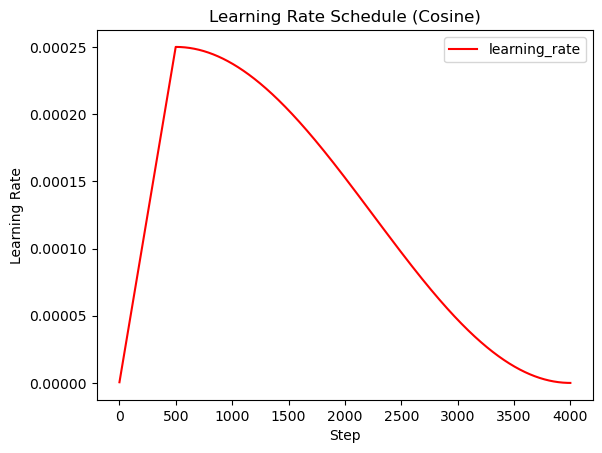

In [54]:
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []

# step() 호출하면서 학습률 추적
for step_num in range(4000):
    lrs.append(test_schedule.step())

# 시각화
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule (Cosine)')
plt.show()

In [55]:
config.n_seq = 128
pre_train_model = build_model_pre_train(config)

# GPU/CPU 자동 선택
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

# 더미 입력 생성 (batch=10, seq_len=128)
enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example   = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

# 모델 summary 출력
summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

Layer (type:depth-idx)                                       Output Shape              Param #
PreTrainModel                                                [10, 2]                   --
├─BERT: 1-1                                                  [10, 64]                  --
│    └─SharedEmbedding: 2-1                                  [10, 128, 64]             512,000
│    └─PositionEmbedding: 2-2                                [10, 128, 64]             --
│    │    └─Embedding: 3-1                                   [10, 128, 64]             8,192
│    └─Embedding: 2-3                                        [10, 128, 64]             128
│    └─LayerNorm: 2-4                                        [10, 128, 64]             128
│    └─Dropout: 2-5                                          [10, 128, 64]             --
│    └─ModuleList: 2-6                                       --                        --
│    │    └─EncoderLayer: 3-2                                [10, 128, 64]           

In [56]:
epochs = 10
batch_size = 64

# 총 train step 계산 (배치 개수 × epoch)
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)

# 학습률 스케줄러 (Warmup + Cosine Decay)
learning_rate_scheduler = CosineSchedule(
    train_steps=train_steps,
    warmup_steps=max(100, train_steps // 10)  # 최소 100 step 이상 warmup
)

# 옵티마이저
optimizer = optim.Adam(pre_train_model.parameters(), lr=1e-4)

# 손실 함수
loss_fn_nsp = nn.CrossEntropyLoss()  # NSP (2-class)
loss_fn_mlm = nn.CrossEntropyLoss()  # MLM (multi-class)

train_steps: 20000


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memmap → Tensor 변환 후 GPU로 이동
pre_train_inputs = [torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [torch.tensor(np.array(x)).to(device) for x in pre_train_labels]

# Dataset & Dataloader 구성
train_dataset = TensorDataset(
    pre_train_inputs[0],  # enc_tokens
    pre_train_inputs[1],  # segments
    pre_train_labels[0],  # labels_nsp
    pre_train_labels[1]   # labels_mlm
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 모델 GPU로 이동
pre_train_model.to(device)

# 학습 로그 저장용
history = {
    'nsp_loss': [],
    'mlm_loss': [],
    'nsp_acc': [],
    'mlm_acc': []
}

for epoch in range(epochs):
    pre_train_model.train()
    total_loss = 0
    total_nsp_loss = 0
    total_mlm_loss = 0
    total_nsp_acc = 0
    total_mlm_acc = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch

        optimizer.zero_grad()

        # Forward
        logits_nsp, logits_mlm = pre_train_model(enc_tokens_batch, segments_batch)

        # 라벨 타입 보정
        labels_nsp_batch = labels_nsp_batch.long()
        labels_mlm_batch = labels_mlm_batch.clamp(0, config.n_vocab - 1).long()

        # Loss 계산
        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(
            logits_mlm.view(-1, logits_mlm.shape[-1]),
            labels_mlm_batch.view(-1)
        )

        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()

        # Backpropagation
        total_loss_batch.backward()
        optimizer.step()

        # Accuracy 계산
        nsp_acc = (logits_nsp.argmax(dim=-1) == labels_nsp_batch).float().mean()
        mlm_acc = (logits_mlm.argmax(dim=-1) == labels_mlm_batch).float().mean()

        total_nsp_acc += nsp_acc.item()
        total_mlm_acc += mlm_acc.item()

    # Epoch 평균 기록
    history['nsp_loss'].append(total_nsp_loss / len(train_dataloader))
    history['mlm_loss'].append(total_mlm_loss / len(train_dataloader))
    history['nsp_acc'].append(total_nsp_acc / len(train_dataloader))
    history['mlm_acc'].append(total_mlm_acc / len(train_dataloader))

    # 로그 출력
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Loss: {total_loss / len(train_dataloader):.4f}, "
        f"NSP Loss: {total_nsp_loss / len(train_dataloader):.4f}, "
        f"MLM Loss: {total_mlm_loss / len(train_dataloader):.4f}, "
        f"NSP Accuracy: {total_nsp_acc / len(train_dataloader):.4f}, "
        f"MLM Accuracy: {total_mlm_acc / len(train_dataloader):.4f}"
    )

    # 모델 저장 
    torch.save(pre_train_model.state_dict(), f"bert_pre_train_epoch_{epoch+1}.pt")

Epoch 1/10 - Loss: 9.0404, NSP Loss: 0.6625, MLM Loss: 8.3779, NSP Accuracy: 0.5971, MLM Accuracy: 0.7244
Epoch 2/10 - Loss: 8.7776, NSP Loss: 0.6587, MLM Loss: 8.1189, NSP Accuracy: 0.5993, MLM Accuracy: 0.8693
Epoch 3/10 - Loss: 8.7763, NSP Loss: 0.6580, MLM Loss: 8.1184, NSP Accuracy: 0.5963, MLM Accuracy: 0.8693
Epoch 4/10 - Loss: 8.7758, NSP Loss: 0.6576, MLM Loss: 8.1182, NSP Accuracy: 0.5982, MLM Accuracy: 0.8693
Epoch 5/10 - Loss: 8.7755, NSP Loss: 0.6574, MLM Loss: 8.1182, NSP Accuracy: 0.5962, MLM Accuracy: 0.8693
Epoch 6/10 - Loss: 8.7753, NSP Loss: 0.6571, MLM Loss: 8.1181, NSP Accuracy: 0.5990, MLM Accuracy: 0.8693
Epoch 7/10 - Loss: 8.7752, NSP Loss: 0.6570, MLM Loss: 8.1181, NSP Accuracy: 0.5986, MLM Accuracy: 0.8693
Epoch 8/10 - Loss: 8.7747, NSP Loss: 0.6565, MLM Loss: 8.1181, NSP Accuracy: 0.5992, MLM Accuracy: 0.8693
Epoch 9/10 - Loss: 8.7744, NSP Loss: 0.6563, MLM Loss: 8.1181, NSP Accuracy: 0.6041, MLM Accuracy: 0.8693
Epoch 10/10 - Loss: 8.7716, NSP Loss: 0.6535, 

##### 프로젝트 결과

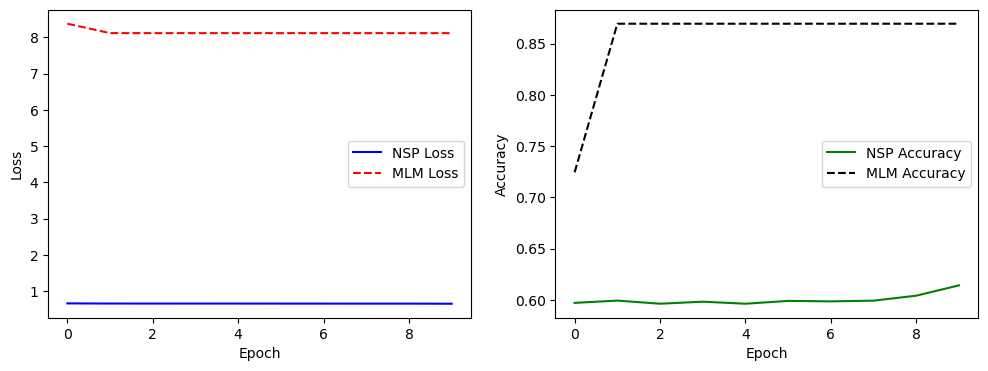

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# (왼쪽) NSP/MLM Loss
plt.subplot(1, 2, 1)
plt.plot(history['nsp_loss'], 'b-', label='NSP Loss')
plt.plot(history['mlm_loss'], 'r--', label='MLM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# (오른쪽) NSP/MLM Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.plot(history['mlm_acc'], 'k--', label='MLM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 회고

이번 프로젝트는 노드를 충실히 따라가며 한국어 위키피디아 코퍼스를 활용해 BERT 사전학습을 직접 구현하는 데 초점을 맞추었다. 

프로젝트에서 제시한 1M 이하의 파라미터 제한을 만족하기 위해 약 92만 개의 파라미터를 가진 경량 BERT 모델을 구축하였고, 보카브 사이즈는 8,000으로 설정하였다.

학습 과정에서는 BERT의 핵심 과제인 MLM(Masked Language Modeling)과 NSP(Next Sentence Prediction)을 구현하였으며, 

이를 위해 트랜스포머의 Encoder 구조를 기반으로 멀티헤드 어텐션, 포지션와이즈 피드포워드 네트워크, 임베딩 레이어 등을 직접 구성하였다. 

학습은 총 10 epoch 동안 진행되었고, 그 결과 NSP Loss는 0.6625에서 0.6535로, MLM Loss는 8.3779에서 8.1181로 점차 감소하였다. 

또한 NSP 정확도는 약 61.4%, MLM 정확도는 약 86.9%에 도달하여 모델이 정상적으로 학습되고 있음을 확인할 수 있었다. 

특히 Warmup과 Cosine Decay를 적용한 학습률 스케줄러가 학습의 안정성에 크게 기여한 것으로 보인다.

아쉬운 점은 전체 위키피디아 코퍼스에서 생성된 약 91만 개의 학습 인스턴스 중 128,000개만 사용하여 학습을 진행했다는 점이다. 

또한 10 epoch라는 짧은 학습 기간 역시 성능을 제약한 요인으로 작용했다고 생각한다. 

그 결과 NSP 정확도가 61% 수준에 머문 것도 데이터와 학습량 부족의 영향이 컸을 것으로 보인다.

이번 프로젝트를 통해 BERT 사전학습의 구조와 원리를 직접 구현하며 이론적 이해를 실제로 체득할 수 있었고, 학습 안정성을 위한 학습률 스케줄러의 효과를 경험할 수 있었다. 

향후에는 이번에 사전학습시킨 모델을 파인튜닝하여 다운스트림 태스크에 적용해보고, 더 많은 데이터와 자원을 활용해 성능을 개선하는 실험을 진행해보고 싶다.